In [1]:
import sys
dir = '/home/jjwhit/rcGAN/'
sys.path.append(dir)
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob
from matplotlib import cm
import torch
from scipy import ndimage
from utils.mri.math import tensor_to_complex_np
import yaml
import json
import types
from data.lightning.MassMappingDataModule import MMDataModule
from data.lightning.MassMappingDataModule import MMDataTransform 
from models.lightning.mmGAN import mmGAN

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [128]:
all_files  = glob.glob(r'/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_train/*.npy')

In [18]:
len(all_files)


8500

In [138]:
#GIF of  simulations
images = []
frames = [np.load(file) for file in all_files[:100]]
# Normalize and scale the float64 values to uint8 in the range [0, 255]
scaled_frames = [(frame - np.min(frame)) / (np.max(frame) - np.min(frame)) * 255 for frame in frames]
uint8_frames = [np.uint8(frame) for frame in scaled_frames]
coloured_frames  = [np.uint8(cm.magma(frame)*255) for frame in uint8_frames]

#imgs = np.stack(uint8_frames)
imgs = np.stack(coloured_frames)

# Save the GIF with the desired parameters
Image.fromarray((imgs[0])).save("/share/gpu0/jjwhit/plots/simulations.gif", save_all=True, append_images=[Image.fromarray(img) for img in imgs[1:]], duration=250, loop=0)


In [25]:
def load_object(dct):
    return types.SimpleNamespace(**dct)
torch.set_float32_matmul_precision('medium')

with open(dir+'configs/mass_map.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg = json.loads(json.dumps(cfg), object_hook=load_object)

dm = MMDataModule(cfg)
fig_count = 1
dm.setup()
test_loader = dm.test_dataloader()

with torch.no_grad():
    mmGAN_model = mmGAN.load_from_checkpoint(
        checkpoint_path='/share/gpu0/jjwhit/mass_map/mm_models/mmgan_training_manual_2/checkpoint_best.ckpt')

    mmGAN_model.cuda()

    mmGAN_model.eval()

In [30]:
#GIF of cosmos posterior samples
gens_mmGAN = torch.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_samps_manual')
cosmos_samps = {
    'mmGAN': [],
}
for z in range(32):
    cosmos_samps['mmGAN'].append(ndimage.rotate(torch.tensor(
        tensor_to_complex_np((gens_mmGAN[z] *cfg. kappa_std + cfg.kappa_mean).cpu().detach())).numpy(), 180))


In [33]:
np_samps[method][l]

AttributeError: 'dict' object has no attribute 'shape'

In [37]:
images = []
frames = [cosmos_samps['mmGAN'][i].real for i in range(32)]
scaled_frames = [(frame - np.min(frame)) / (np.max(frame) - np.min(frame)) * 255 for frame in frames]
uint8_frames = [np.uint8(frame) for frame in scaled_frames]
coloured_frames  = [np.uint8(cm.magma(frame)*255) for frame in uint8_frames]

#imgs = np.stack(uint8_frames)
imgs = np.stack(coloured_frames)
Image.fromarray((imgs[0])).save("/share/gpu0/jjwhit/plots/cosmos_samples_new.gif", save_all=True, append_images=[Image.fromarray(img) for img in imgs[1:]], duration=200, loop=0)

In [18]:
#Make gif of simulation posterior samples (gif with gt constant on the left?)
np_gt = np.load("/share/gpu0/jjwhit/samples/np_gt_2.npy")
np_samps = np.load("/share/gpu0/jjwhit/samples/np_samps_2.npy")

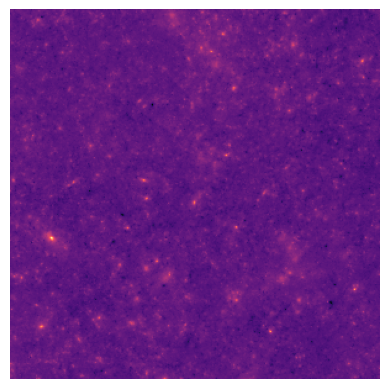

In [21]:
plt.imshow(np_gt.real,  cmap='magma')
plt.axis('off')
#plt.colorbar()
#plt.show()
plt.savefig("/share/gpu0/jjwhit/plots/map_2_gt_nocb.png",bbox_inches='tight', dpi=300)

In [20]:
new_frames = [np_samps[i].real for i in range(32)]
scaled_frames = [(frame - np.min(frame)) / (np.max(frame) - np.min(frame)) * 255 for frame in new_frames]
uint8_frames = [np.uint8(frame) for frame in scaled_frames]
coloured_frames  = [np.uint8(cm.magma(frame)*255) for frame in uint8_frames]
imgs = np.stack(coloured_frames)
#TODO: Colourbar
Image.fromarray((imgs[0])).save("/share/gpu0/jjwhit/plots/map_2.gif", save_all=True, append_images=[Image.fromarray(img) for img in imgs[1:]], duration=250, loop=0)